# Model engineering with multiplate datasets

- SMEB data
- Displacement data
- warevents data
- google events
    - Interesting columns: total_events_size +
               events_perc_QC4_size + root_events_size + goldstein_mean +
               goldstein_median + numarticles_perc90 + avgtone_min + goldavg_median +
               goldavg_perc10 + avgweight_perc10 + Strategic_developments +
               delta_Strategic_developments + delta_Riots

In [68]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
%matplotlib inline

In [69]:
# selected model choice
TARGET = 'event_Price_SMEB_total_sanswater_median_up_10'
months_in_train = 0.8 # percentage of months in the train
# targets can be ['event_Price_SMEB_total_sanswater_up_10', 
# 'event_Price_SMEB_total_sanswater_down_10', 
# 'event_Price_SMEB_total_sanswater_median_up_10', 
# 'event_Price_SMEB_total_sanswater_median_down_10']

In [70]:
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/cockpit_file_agg_naintrap_event.csv'
data_smeb = pd.read_csv(fname, index_col=0)
# select columns to keep 
tt = [c for c in data_smeb.columns.tolist() if 'event_Price_SMEB_total_sanswater' in c]
# print(tt)
cols = ['q_sbd', 'q_gov','admin3Name_en','q_district','month', TARGET]
data_smeb = data_smeb[cols]
# data_smeb.head()

# import displacement
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/04.feature_eng.displacement.csv'
data_IDP = pd.read_csv(fname, index_col=0)
# select columns to keep 
cols = ['q_sbd', 'q_gov', 'q_district','month', 
 'inc_max_IDPs_sum',
 'inc_max_pre_conf_pop_remained_mean',
 'delta_rel_max_IDPs_sum',
 'delta_abs_max_pre_conf_pop_remained_mean']
data_IDP = data_IDP[cols]
# data_IDP.head()

# import warevents
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/ext_data_warevents_v3.csv'
data_war = pd.read_csv(fname, index_col=0)
# fill na with 0
data_war = data_war.fillna(0)

# join war and smeb data
data_smeb = data_smeb.merge(data_war, left_on=['admin3Name_en','month'], right_on = ['admin3','month'], how='left')
# join the data based on the smeb data
data = data_smeb.merge(data_IDP, left_on=['q_sbd','month','q_gov','q_district'], right_on = ['q_sbd','month','q_gov','q_district'], how='left')
assert data.shape[0] == data_smeb.shape[0]
data

q_sbd q_gov admin3Name_en q_district  month  \
0     SY020001  SY02        Atareb     SY0200      1   
1     SY020001  SY02        Atareb     SY0200      2   
2     SY020001  SY02        Atareb     SY0200      3   
3     SY020001  SY02        Atareb     SY0200      4   
4     SY020001  SY02        Atareb     SY0200      5   
...        ...   ...           ...        ...    ...   
1821  SY110302  SY11     Jurneyyeh     SY1103     18   
1822  SY110302  SY11     Jurneyyeh     SY1103     19   
1823  SY110302  SY11     Jurneyyeh     SY1103     20   
1824  SY110302  SY11     Jurneyyeh     SY1103     21   
1825  SY110302  SY11     Jurneyyeh     SY1103     22   

      event_Price_SMEB_total_sanswater_median_up_10       X     admin3  \
0                                               NaN    10.0     Atareb   
1                                               NaN   235.0     Atareb   
2                                               NaN   460.0     Atareb   
3                                               0.0   685.0     Atareb   
4                                               1.0   910.0     Atareb   
...                                             ...     ...        ...   
1821                                            1.0  3951.0  Jurneyyeh   
1822                                            1.0  4176.0  Jurneyyeh   
1823                                            0.0  4401.0  Jurneyyeh   
1824                                            0.0  4626.0  Jurneyyeh   
1825                                            0.0  4851.0  Jurneyyeh   

      Battles  Explosions_Remote_violence  ...  delta_Protests  \
0        12.0                         5.0  ...             0.0   
1         0.0                         1.0  ...            -2.0   
2         3.0                        15.0  ...            -1.0   
3        24.0                         4.0  ...             0.0   
4        11.0                         5.0  ...             3.0   
...       ...                         ...  ...             ...   
1821      0.0                         1.0  ...             0.0   
1822      0.0                         0.0  ...             0.0   
1823      0.0                         0.0  ...             0.0   
1824      0.0                         1.0  ...             0.0   
1825      0.0                         0.0  ...             0.0   

      delta_perc_Riots  delta_Riots  delta_perc_warevents  delta_warevents  \
0                  0.0          0.0              0.000000              0.0   
1                  0.0          0.0             -1.164706            -18.0   
2                  0.0          0.0              1.035294             16.0   
3                  0.0          0.0              1.617647             25.0   
4                  0.0          0.0             -0.647059            -10.0   
...                ...          ...                   ...              ...   
1821               0.0          0.0              5.500000              1.0   
1822               0.0          0.0             -5.500000             -1.0   
1823               0.0          0.0              0.000000              0.0   
1824               0.0          0.0              5.500000              1.0   
1825               0.0          0.0             -5.500000             -1.0   

      warevents_norm  inc_max_IDPs_sum  inc_max_pre_conf_pop_remained_mean  \
0           0.000000               NaN                                 NaN   
1          -1.421294               NaN                                 NaN   
2           1.358990               NaN                                 NaN   
3           2.094948               NaN                                 NaN   
4          -0.767109               NaN                                 NaN   
...              ...               ...                                 ...   
1821        1.581139             False                               False   
1822       -1.581139             False                               False   
1823        0.0

In [71]:
# drop na 
data = data.dropna().reset_index()
data

index     q_sbd q_gov admin3Name_en q_district  month  \
0        6  SY020001  SY02        Atareb     SY0200      7   
1        9  SY020001  SY02        Atareb     SY0200     10   
2       10  SY020001  SY02        Atareb     SY0200     11   
3       11  SY020001  SY02        Atareb     SY0200     12   
4       12  SY020001  SY02        Atareb     SY0200     13   
..     ...       ...   ...           ...        ...    ...   
306   1819  SY110302  SY11     Jurneyyeh     SY1103     16   
307   1820  SY110302  SY11     Jurneyyeh     SY1103     17   
308   1821  SY110302  SY11     Jurneyyeh     SY1103     18   
309   1822  SY110302  SY11     Jurneyyeh     SY1103     19   
310   1825  SY110302  SY11     Jurneyyeh     SY1103     22   

     event_Price_SMEB_total_sanswater_median_up_10       X     admin3  \
0                                              0.0  1360.0     Atareb   
1                                              0.0  2035.0     Atareb   
2                                              0.0  2260.0     Atareb   
3                                              0.0  2485.0     Atareb   
4                                              0.0  2710.0     Atareb   
..                                             ...     ...        ...   
306                                            0.0  3501.0  Jurneyyeh   
307                                            1.0  3726.0  Jurneyyeh   
308                                            1.0  3951.0  Jurneyyeh   
309                                            1.0  4176.0  Jurneyyeh   
310                                            0.0  4851.0  Jurneyyeh   

     Battles  ...  delta_Protests  delta_perc_Riots  delta_Riots  \
0        2.0  ...            -1.0               0.0          0.0   
1        2.0  ...             2.0               0.0          0.0   
2        2.0  ...            18.0               0.0          0.0   
3        9.0  ...           -18.0               0.0          0.0   
4        2.0  ...            -1.0               0.0          0.0   
..       ...  ...             ...               ...          ...   
306      0.0  ...             0.0               0.0          0.0   
307      0.0  ...             0.0               0.0          0.0   
308      0.0  ...             0.0               0.0          0.0   
309      0.0  ...             0.0               0.0          0.0   
310      0.0  ...             0.0               0.0          0.0   

     delta_perc_warevents  delta_warevents  warevents_norm  inc_max_IDPs_sum  \
0               -0.194118             -3.0       -0.194698              True   
1               -0.064706             -1.0       -0.031152             False   
2                0.776471             12.0        1.031898             False   
3               -0.517647             -8.0       -0.603563             False   
4               -0.647059            -10.0       -0.767109             False   
..                    ...              ...             ...               ...   
306              0.000000              0.0        0.000000             False   
307              0.000000              0.0        0.000000             False   
308              5.500000              1.0        1.581139             False   
309             -5.500000             -1.0       -1.581139             False   
310             -5.500000             -1.0       -1.581139             False   

     inc_max_pre_conf_pop_remained_mean  delta_rel_max_IDPs_sum  \
0                                 False                0.005044   
1                                 False               -0.009285   
2                                 False               -0.032232   
3                                 False               -0.001374   
4                                 False               -0.006094   
..                                  ...                     ...   
306                               False               -0.428571   
307                               False                0.000000   
30

In [72]:
# check what months we have
idx_train = int(len(data['month'].value_counts().sort_index().index.values) * months_in_train)
train_split = data['month'].value_counts().sort_index().index.values[idx_train]

In [73]:
# check what months we have
idx_train = int(len(data['month'].value_counts().sort_index().index.values) * months_in_train)
train_split = data['month'].value_counts().sort_index().index.values[idx_train]
data_train = data[(data['month']<=train_split)]
data_test = data[(data['month']>train_split)]

print('Train test split:')
data_train.shape[0]/(data_test.shape[0]+data_train.shape[0])

Train test split:


0.8038585209003215

In [74]:
# features to take
data.columns

Index(['index', 'q_sbd', 'q_gov', 'admin3Name_en', 'q_district', 'month',
       'event_Price_SMEB_total_sanswater_median_up_10', 'X', 'admin3',
       'Battles', 'Explosions_Remote_violence', 'Protests', 'Riots',
       'Strategic_developments', 'Violence_against_civilians', 'warevents',
       'delta_perc_Explosions_Remote_violence',
       'delta_Explosions_Remote_violence', 'delta_perc_Strategic_developments',
       'delta_Strategic_developments', 'delta_perc_Battles', 'delta_Battles',
       'delta_perc_Violence_against_civilians',
       'delta_Violence_against_civilians', 'delta_perc_Protests',
       'delta_Protests', 'delta_perc_Riots', 'delta_Riots',
       'delta_perc_warevents', 'delta_warevents', 'warevents_norm',
       'inc_max_IDPs_sum', 'inc_max_pre_conf_pop_remained_mean',
       'delta_rel_max_IDPs_sum', 'delta_abs_max_pre_conf_pop_remained_mean'],
      dtype='object')

In [77]:
numeric_features = ['Battles','Explosions_Remote_violence','Protests','Riots','Strategic_developments','Violence_against_civilians',
                    'warevents',
           'delta_perc_Explosions_Remote_violence',
'delta_Explosions_Remote_violence',
'delta_perc_Strategic_developments',
'delta_Strategic_developments',
'delta_perc_Battles',
'delta_Battles',
'delta_perc_Violence_against_civilians',
'delta_Violence_against_civilians',
'delta_perc_Protests',
'delta_Protests',
'delta_perc_Riots',
'delta_Riots',
'delta_perc_warevents',
    'delta_warevents',
            'warevents_norm','delta_rel_max_IDPs_sum',
            'delta_abs_max_pre_conf_pop_remained_mean', 'inc_max_IDPs_sum',
            'inc_max_pre_conf_pop_remained_mean']

for c in numeric_features:
    data_train[c] = pd.to_numeric(data_train[c]).astype(float)
    data_test[c] = pd.to_numeric(data_test[c]).astype(float)
    
cols_to_keep = [numeric_features, [TARGET]]
cols_to_keep = [item for sublist in cols_to_keep for item in sublist]
data_test = data_test[cols_to_keep]
data_train = data_train[cols_to_keep]

# training data
X_train = data_train.drop(columns=TARGET)
y_train = data_train[TARGET]

# test data
X_test = data_test.drop(columns=TARGET)
y_test = data_test[TARGET]

clf = RandomForestClassifier(
 n_estimators=100,
 random_state= 42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# always predict 0
y_0 = np.zeros(len(y_test))
print(f'Accuracy score always predict 0 in test set: {accuracy_score(y_test, y_0)}')
# always predict 1
y_1 = np.ones(len(y_test))
print(f'Accuracy score always predict 1 in test set: {accuracy_score(y_test, y_1)}')
print(f'Train score: {accuracy_score(y_train, clf.predict(X_train))}, Test score: {accuracy_score(y_test, y_pred)}')


Accuracy score always predict 0 in test set: 0.819672131147541
Accuracy score always predict 1 in test set: 0.18032786885245902
Train score: 0.992, Test score: 0.7377049180327869


In [76]:
feat_imp = dict(zip(X_train.columns, clf.feature_importances_))
df_feat_imp = pd.DataFrame(feat_imp, index=['Feature_importance']).T.sort_values(by='Feature_importance', ascending=False)
df_feat_imp

Feature_importance
delta_rel_max_IDPs_sum                              0.109768
warevents_norm                                      0.093947
delta_perc_warevents                                0.080894
delta_perc_Battles                                  0.066488
delta_perc_Explosions_Remote_violence               0.059922
warevents                                           0.056444
delta_warevents                                     0.049657
delta_perc_Strategic_developments                   0.047807
delta_perc_Violence_against_civilians               0.047443
Explosions_Remote_violence                          0.045062
delta_Explosions_Remote_violence                    0.038539
delta_Protests                                      0.036168
delta_Battles                                       0.035779
delta_Strategic_developments                        0.033777
Battles                                             0.029995
delta_Violence_against_civilians                    0.029204
delta_perc_Protests                                 0.028142
Strategic_developments                              0.025955
inc_max_IDPs_sum                                    0.021138
Violence_against_civilians                          0.020990
delta_abs_max_pre_conf_pop_remained_mean            0.018962
Protests                                            0.015423
inc_max_pre_conf_pop_remained_mean                  0.006998
delta_perc_Riots                                    0.000660
delta_Riots                                         0.000499
Riots                                               0.000338

## Check multiple y

In [85]:
def check_multiple_y_random_forest(TARGET, months_in_train=0.8):
    # Import data
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/cockpit_file_agg_naintrap_event.csv'
    data_smeb = pd.read_csv(fname, index_col=0)
    # select columns to keep 
    tt = [c for c in data_smeb.columns.tolist() if 'event_Price_SMEB_total_sanswater' in c]
    # print(tt)
    cols = ['q_sbd', 'q_gov','admin3Name_en','q_district','month', TARGET]
    data_smeb = data_smeb[cols]
    # data_smeb.head()

    # import displacement
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/04.feature_eng.displacement.csv'
    data_IDP = pd.read_csv(fname, index_col=0)
    # select columns to keep 
    cols = ['q_sbd', 'q_gov', 'q_district','month', 
     'inc_max_IDPs_sum',
     'inc_max_pre_conf_pop_remained_mean',
     'delta_rel_max_IDPs_sum',
     'delta_abs_max_pre_conf_pop_remained_mean']
    data_IDP = data_IDP[cols]
    # data_IDP.head()

    # import warevents
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/ext_data_warevents_v3.csv'
    data_war = pd.read_csv(fname, index_col=0)
    # fill na with 0
    data_war = data_war.fillna(0)

    # join war and smeb data
    data_smeb = data_smeb.merge(data_war, left_on=['admin3Name_en','month'], right_on = ['admin3','month'], how='left')
    # join the data based on the smeb data
    data = data_smeb.merge(data_IDP, left_on=['q_sbd','month','q_gov','q_district'], right_on = ['q_sbd','month','q_gov','q_district'], how='left')
    assert data.shape[0] == data_smeb.shape[0]
    
    # drop na
    data = data.dropna().reset_index()
    
    # traintestsplit
    idx_train = int(len(data['month'].value_counts().sort_index().index.values) * months_in_train)
    train_split = data['month'].value_counts().sort_index().index.values[idx_train]
    data_train = data[(data['month']<=train_split)]
    data_test = data[(data['month']>train_split)]

    print('Train test split:')
    data_train.shape[0]/(data_test.shape[0]+data_train.shape[0])

    
    numeric_features = ['Battles',
                        'Explosions_Remote_violence',
                        'Protests',
                        'Riots',
                        'Strategic_developments',
                        'Violence_against_civilians',
#                         'warevents',
#                         'delta_perc_Explosions_Remote_violence',
#                         'delta_Explosions_Remote_violence',
#                         'delta_perc_Strategic_developments',
#                         'delta_Strategic_developments',
#                         'delta_perc_Battles',
#                         'delta_Battles',
#                         'delta_perc_Violence_against_civilians',
#                         'delta_Violence_against_civilians',
#                         'delta_perc_Protests',
#                         'delta_Protests',
#                         'delta_perc_Riots',
#                         'delta_Riots',
#                         'delta_perc_warevents',
#                         'delta_warevents',
#                         'warevents_norm',
                        'delta_rel_max_IDPs_sum',
                        'delta_abs_max_pre_conf_pop_remained_mean', 
                        'inc_max_IDPs_sum',
                        'inc_max_pre_conf_pop_remained_mean']

    for c in numeric_features:
        data_train[c] = pd.to_numeric(data_train[c]).astype(float)
        data_test[c] = pd.to_numeric(data_test[c]).astype(float)

    cols_to_keep = [numeric_features, [TARGET]]
    cols_to_keep = [item for sublist in cols_to_keep for item in sublist]
    data_test = data_test[cols_to_keep]
    data_train = data_train[cols_to_keep]

    # training data
    X_train = data_train.drop(columns=TARGET)
    y_train = data_train[TARGET]

    # test data
    X_test = data_test.drop(columns=TARGET)
    y_test = data_test[TARGET]

    clf = RandomForestClassifier(
     n_estimators=300,
     random_state= 42)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # always predict 0
    y_0 = np.zeros(len(y_test))
    print(f'Accuracy score always predict 0 in test set: {accuracy_score(y_test, y_0)}')
    # always predict 1
    y_1 = np.ones(len(y_test))
    print(f'Accuracy score always predict 1 in test set: {accuracy_score(y_test, y_1)}')
    print(f'Train score: {accuracy_score(y_train, clf.predict(X_train))}, Test score: {accuracy_score(y_test, y_pred)}')


In [86]:
pd.options.mode.chained_assignment = None
for TARGET in ['event_Price_SMEB_total_sanswater_up_10', 
'event_Price_SMEB_total_sanswater_down_10', 
'event_Price_SMEB_total_sanswater_median_up_10', 
'event_Price_SMEB_total_sanswater_median_down_10']:
    print(f'Target: {TARGET}')
    check_multiple_y_random_forest(TARGET, months_in_train=0.8)
    print(' ')

Target: event_Price_SMEB_total_sanswater_up_10
Train test split:
Accuracy score always predict 0 in test set: 0.9367088607594937
Accuracy score always predict 1 in test set: 0.06329113924050633
Train score: 0.9899328859060402, Test score: 0.9113924050632911
 
Target: event_Price_SMEB_total_sanswater_down_10
Train test split:
Accuracy score always predict 0 in test set: 0.9620253164556962
Accuracy score always predict 1 in test set: 0.0379746835443038
Train score: 1.0, Test score: 0.9620253164556962
 
Target: event_Price_SMEB_total_sanswater_median_up_10
Train test split:
Accuracy score always predict 0 in test set: 0.819672131147541
Accuracy score always predict 1 in test set: 0.18032786885245902
Train score: 0.956, Test score: 0.7049180327868853
 
Target: event_Price_SMEB_total_sanswater_median_down_10
Train test split:
Accuracy score always predict 0 in test set: 0.8852459016393442
Accuracy score always predict 1 in test set: 0.11475409836065574
Train score: 0.996, Test score: 0.8852

## Check adding of features

In [115]:
from sklearn.linear_model import LogisticRegression

def check_multiple_features_random_forest(TARGET,numeric_features, months_in_train=0.8):
    # Import data
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/cockpit_file_agg_naintrap_event.csv'
    data_smeb = pd.read_csv(fname, index_col=0)
    # select columns to keep 
    tt = [c for c in data_smeb.columns.tolist() if 'event_Price_SMEB_total_sanswater' in c]
    # print(tt)
    cols = ['q_sbd', 'q_gov','admin3Name_en','q_district','month', TARGET]
    data_smeb = data_smeb[cols]
    # data_smeb.head()

    # import displacement
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/04.feature_eng.displacement.csv'
    data_IDP = pd.read_csv(fname, index_col=0)
    # select columns to keep 
    cols = ['q_sbd', 'q_gov', 'q_district','month', 
     'inc_max_IDPs_sum',
     'inc_max_pre_conf_pop_remained_mean',
     'delta_rel_max_IDPs_sum',
     'delta_abs_max_pre_conf_pop_remained_mean']
    data_IDP = data_IDP[cols]
    # data_IDP.head()

    # import warevents
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/ext_data_warevents_v3.csv'
    data_war = pd.read_csv(fname, index_col=0)
    # fill na with 0
    data_war = data_war.fillna(0)

    # join war and smeb data
    data_smeb = data_smeb.merge(data_war, left_on=['admin3Name_en','month'], right_on = ['admin3','month'], how='left')
    # join the data based on the smeb data
    data = data_smeb.merge(data_IDP, left_on=['q_sbd','month','q_gov','q_district'], right_on = ['q_sbd','month','q_gov','q_district'], how='left')
    assert data.shape[0] == data_smeb.shape[0]
    
    # drop na
    data = data.dropna().reset_index()
    
    # traintestsplit
    idx_train = int(len(data['month'].value_counts().sort_index().index.values) * months_in_train)
    train_split = data['month'].value_counts().sort_index().index.values[idx_train]
    data_train = data[(data['month']<=train_split)]
    data_test = data[(data['month']>train_split)]

#     print('Train test split:')
    data_train.shape[0]/(data_test.shape[0]+data_train.shape[0])


    for c in numeric_features:
        data_train[c] = pd.to_numeric(data_train[c]).astype(float)
        data_test[c] = pd.to_numeric(data_test[c]).astype(float)

    cols_to_keep = [numeric_features, [TARGET]]
    cols_to_keep = [item for sublist in cols_to_keep for item in sublist]
    data_test = data_test[cols_to_keep]
    data_train = data_train[cols_to_keep]

    # training data
    X_train = data_train.drop(columns=TARGET)
    y_train = data_train[TARGET]

    # test data
    X_test = data_test.drop(columns=TARGET)
    y_test = data_test[TARGET]

#     clf = RandomForestClassifier(
#      n_estimators=1000,
#      random_state= 42)

    clf = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10)
#     clf = LogisticRegression(solver = 'lbfgs')

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # always predict 0
    y_0 = np.zeros(len(y_test))
#     print(f'Accuracy score always predict 0 in test set: {accuracy_score(y_test, y_0)}')
    # always predict 1
    y_1 = np.ones(len(y_test))

#     print(f'Accuracy score always predict 1 in test set: {accuracy_score(y_test, y_1)}')
#     print(f'Train score: {accuracy_score(y_train, clf.predict(X_train))}, Test score: {accuracy_score(y_test, y_pred)}')

    return accuracy_score(y_test, y_0), accuracy_score(y_test, y_1), accuracy_score(y_test, y_pred)

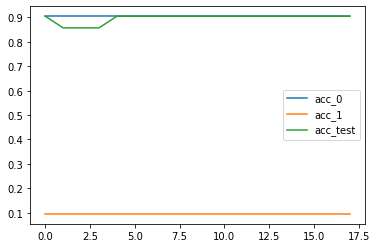

In [124]:
numeric_features = ['delta_rel_max_IDPs_sum',
                        'delta_abs_max_pre_conf_pop_remained_mean', 
                        'inc_max_IDPs_sum',
                        'inc_max_pre_conf_pop_remained_mean',
                        'Battles',
                        'Explosions_Remote_violence',
                        'Protests',
                        'Riots',
                        'Strategic_developments',
                        'Violence_against_civilians',
                        'warevents',
                        'delta_perc_Explosions_Remote_violence',
#                         'delta_Explosions_Remote_violence',
                        'delta_perc_Strategic_developments',
#                         'delta_Strategic_developments',
                        'delta_perc_Battles',
#                         'delta_Battles',
                        'delta_perc_Violence_against_civilians',
#                         'delta_Violence_against_civilians',
                        'delta_perc_Protests',
#                         'delta_Protests',
                        'delta_perc_Riots',
#                         'delta_Riots',
                        'delta_perc_warevents',
#                         'delta_warevents',
                        'warevents_norm'
                   ]

#     return accuracy_score(y_test, y_0), accuracy_score(y_test, y_1), accuracy_score(y_test, y_pred)
acc_0 = [] # predict always 0
acc_1 = [] # predict always 1
acc_test = [] # test score
for ii in range(1,len(numeric_features)):
    features = numeric_features[0:ii]
    a,b,c = check_multiple_features_random_forest('event_Price_SMEB_total_sanswater_up_10',features, months_in_train=0.9)
    acc_0.append(a)
    acc_1.append(b)
    acc_test.append(c)
    
plt.plot(acc_0, label='acc_0')
plt.plot(acc_1, label='acc_1')
plt.plot(acc_test, label='acc_test')
plt.legend()
plt.show()


In [125]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [126]:
y_test.values

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

## Train test split

In [64]:
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/cockpit_file_agg_naintrap_event.csv'
data_smeb = pd.read_csv(fname, index_col=0)
# select columns to keep 
tt = [c for c in data_smeb.columns.tolist() if 'event_Price_SMEB_total_sanswater' in c]
# print(tt)
cols = ['q_sbd', 'q_gov','admin3Name_en','q_district','month', TARGET]
data_smeb = data_smeb[cols]
# data_smeb.head()

# import displacement
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/04.feature_eng.displacement.csv'
data_IDP = pd.read_csv(fname, index_col=0)
# select columns to keep 
cols = ['q_sbd', 'q_gov', 'q_district','month', 
 'inc_max_IDPs_sum',
 'inc_max_pre_conf_pop_remained_mean',
 'delta_rel_max_IDPs_sum',
 'delta_abs_max_pre_conf_pop_remained_mean']
data_IDP = data_IDP[cols]
# data_IDP.head()

# import warevents
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/ext_data_warevents_v3.csv'
data_war = pd.read_csv(fname, index_col=0)
# fill na with 0
data_war = data_war.fillna(0)

# join war and smeb data
data_smeb = data_smeb.merge(data_war, left_on=['admin3Name_en','month'], right_on = ['admin3','month'], how='left')
# join the data based on the smeb data
data = data_smeb.merge(data_IDP, left_on=['q_sbd','month','q_gov','q_district'], right_on = ['q_sbd','month','q_gov','q_district'], how='left')
assert data.shape[0] == data_smeb.shape[0]

# drop na 
data = data.dropna().reset_index()
data

index     q_sbd q_gov admin3Name_en q_district  month  \
0        6  SY020001  SY02        Atareb     SY0200      7   
1        9  SY020001  SY02        Atareb     SY0200     10   
2       10  SY020001  SY02        Atareb     SY0200     11   
3       11  SY020001  SY02        Atareb     SY0200     12   
4       12  SY020001  SY02        Atareb     SY0200     13   
..     ...       ...   ...           ...        ...    ...   
306   1819  SY110302  SY11     Jurneyyeh     SY1103     16   
307   1820  SY110302  SY11     Jurneyyeh     SY1103     17   
308   1821  SY110302  SY11     Jurneyyeh     SY1103     18   
309   1822  SY110302  SY11     Jurneyyeh     SY1103     19   
310   1825  SY110302  SY11     Jurneyyeh     SY1103     22   

     event_Price_SMEB_total_sanswater_median_up_10       X     admin3  \
0                                              0.0  1360.0     Atareb   
1                                              0.0  2035.0     Atareb   
2                                              0.0  2260.0     Atareb   
3                                              0.0  2485.0     Atareb   
4                                              0.0  2710.0     Atareb   
..                                             ...     ...        ...   
306                                            0.0  3501.0  Jurneyyeh   
307                                            1.0  3726.0  Jurneyyeh   
308                                            1.0  3951.0  Jurneyyeh   
309                                            1.0  4176.0  Jurneyyeh   
310                                            0.0  4851.0  Jurneyyeh   

     Battles  ...  delta_Protests  delta_perc_Riots  delta_Riots  \
0        2.0  ...            -1.0               0.0          0.0   
1        2.0  ...             2.0               0.0          0.0   
2        2.0  ...            18.0               0.0          0.0   
3        9.0  ...           -18.0               0.0          0.0   
4        2.0  ...            -1.0               0.0          0.0   
..       ...  ...             ...               ...          ...   
306      0.0  ...             0.0               0.0          0.0   
307      0.0  ...             0.0               0.0          0.0   
308      0.0  ...             0.0               0.0          0.0   
309      0.0  ...             0.0               0.0          0.0   
310      0.0  ...             0.0               0.0          0.0   

     delta_perc_warevents  delta_warevents  warevents_norm  inc_max_IDPs_sum  \
0               -0.194118             -3.0       -0.194698              True   
1               -0.064706             -1.0       -0.031152             False   
2                0.776471             12.0        1.031898             False   
3               -0.517647             -8.0       -0.603563             False   
4               -0.647059            -10.0       -0.767109             False   
..                    ...              ...             ...               ...   
306              0.000000              0.0        0.000000             False   
307              0.000000              0.0        0.000000             False   
308              5.500000              1.0        1.581139             False   
309             -5.500000             -1.0       -1.581139             False   
310             -5.500000             -1.0       -1.581139             False   

     inc_max_pre_conf_pop_remained_mean  delta_rel_max_IDPs_sum  \
0                                 False                0.005044   
1                                 False               -0.009285   
2                                 False               -0.032232   
3                                 False               -0.001374   
4                                 False               -0.006094   
..                                  ...                     ...   
306                               False               -0.428571   
307                               False                0.000000   
30

In [67]:
numeric_features = ['Battles','Explosions_Remote_violence','Protests','Riots','Strategic_developments','Violence_against_civilians',
                    'warevents',
           'delta_perc_Explosions_Remote_violence',
'delta_Explosions_Remote_violence',
'delta_perc_Strategic_developments',
'delta_Strategic_developments',
'delta_perc_Battles',
'delta_Battles',
'delta_perc_Violence_against_civilians',
'delta_Violence_against_civilians',
'delta_perc_Protests',
'delta_Protests',
'delta_perc_Riots',
'delta_Riots',
'delta_perc_warevents',
    'delta_warevents',
            'warevents_norm','delta_rel_max_IDPs_sum',
            'delta_abs_max_pre_conf_pop_remained_mean', 'inc_max_IDPs_sum',
            'inc_max_pre_conf_pop_remained_mean']

for c in numeric_features:
    data[c] = pd.to_numeric(data[c]).astype(float)
    
cols_to_keep = [numeric_features, [TARGET]]
cols_to_keep = [item for sublist in cols_to_keep for item in sublist]
data = data[cols_to_keep]



X = data.drop(columns=TARGET)
y = data[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(
 n_estimators=1000,
 random_state= 42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# always predict 0
y_0 = np.zeros(len(y_test))
print(f'Accuracy score always predict 0 in test set: {accuracy_score(y_test, y_0)}')
# always predict 1
y_1 = np.ones(len(y_test))
print(f'Accuracy score always predict 1 in test set: {accuracy_score(y_test, y_1)}')
print(f'Train score: {accuracy_score(y_train, clf.predict(X_train))}, Test score: {accuracy_score(y_test, y_pred)}')


Accuracy score always predict 0 in test set: 0.8253968253968254
Accuracy score always predict 1 in test set: 0.1746031746031746
Train score: 0.9879032258064516, Test score: 0.8095238095238095
